<a href="https://colab.research.google.com/github/Tyluuus/MemotionAnalysis/blob/udpates/GSN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSN21Z Projekt 

Celem projektu będzie realizacja tasku B znajdującego się pod challengem Memotion na platformie Kaggle: https://www.kaggle.com/williamscott701/memotion-dataset-7k


Treść zadania: *Task B- Humor Classification: Given an Internet meme, the system has to identify the type of humor expressed. The categories are sarcastic, humorous, and offensive meme. If a meme does not fall under any of these categories, then it is marked as another meme. A meme can have more than one category.*





Dataset: W datasecie znajduje się 6992 memów pobranych z platformy reddit oraz oznaczonych z wykorzystaniem usługi Amazon Mechanical Turk. Oznaczenia znajdują się w pliku csv, który zawiera: 
1.   Nazwę pliku z memem
2.   Tekst uzyskany z wykorzystaniem OCR
3.   Tekst poprawiony
4.   Klasa humorystyczna
5.   Klasa sarkastyczna
6.   Klasa ofensywna
7.   Klasa motywacyjna


## Przygotowanie do użycia kodu

Podłączenie notatnika do dysku Google - potrzebne przy zapisie checkpoint'ów i słowników stanów 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Sklonowanie repozytorium z githuba - pobranie plików składających się na dataset - zdjęć oraz pliku csv, pobierane są również pliki niezbędne do wczytania modelu sieci

In [ ]:
!git clone https://github.com/Tyluuus/MemotionAnalysis.git

Cloning into 'MemotionAnalysis'...
remote: Enumerating objects: 7106, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 7106 (delta 25), reused 3 (delta 1), pack-reused 7063
Receiving objects: 100% (7106/7106), 862.56 MiB | 46.16 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Checking out files: 100% (13992/13992), done.


Instalacja pakietu transformers użytym przy klasyfikatorze BERT

In [ ]:
pip install transformers

     |████████████████████████████████| 3.4 MB 31.1 MB/s 
     |████████████████████████████████| 596 kB 67.6 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 65.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Importy wszystkich bibliotek wykorzystywanych w projekcie

In [ ]:
#Imports

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import cv2
import time
import copy
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
from google.colab.patches import cv2_imshow
from torchtext.legacy.data import Dataset, Example, Field
from torchtext.legacy.data import BucketIterator
from transformers import BertModel
from transformers import BertTokenizer
from torch.optim import Adam
from tqdm import tqdm

Przełączenie na używanie GPU w projekcie jeżeli jest to możliwe

In [ ]:
# Switch to using GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


Określenie:
- czy używany jest wytrenowany model, 
- czy wytrenowane modele powinny być zapisane,
- czy wykonany ma być _tranfer learning_,
- ścieżek do zapisu i odczytu modeli

In [ ]:
# Use trained model variable
use_trained_model = False
save_model = True
image_model_continue_training = False
image_save_model_path = './drive/MyDrive/GSN_dataset/memotion_images_model_30_epoch.pt'
text_save_model_path = './drive/MyDrive/GSN_dataset/memotion_text_model_bert_10_epochs.pt'
image_load_model_path = './MemotionAnalysis/memotion_images_model_1_epoch.pt'
text_load_model_path = './MemotionAnalysis/memotion_text_model_1_epoch.pt'
image_checkpoint_path = './drive/MyDrive/GSN_dataset/checkpoint.pt'
text_checkpoint_path = './drive/MyDrive/GSN_dataset/memotion_text_model_bert_10_epochs_checkpoint.pt'

Określenie liczby epok dla trenowania gałęzi tekstu i obrazu oraz rozmiaru batchy - _same_batch_size_ jest wielkością dla jednoczesnego trenowania obrazu i testu z tą samą wielkością batcha

In [ ]:
text_epochs = 200 # 250
image_epochs = 25 # 20
text_batch_size = 2
image_batch_size = 16

same_batch_size = 32

Pobranie pretrenowanego modelu dla tekstu w razie potrzeby

In [ ]:
# Download text model for 300 epochs
!gdown --id 1-9UMs4-3DO0acalwBUMf7rKHXBg1qV8n

Downloading...
From: https://drive.google.com/uc?id=1-9UMs4-3DO0acalwBUMf7rKHXBg1qV8n
To: /content/memotion_text_model_300_epoch.pt
100% 5.49M/5.49M [00:00<00:00, 49.5MB/s]


## Gałąź przetwarzania obrazu

### Utworzenie zbioru danych na podstawie danych z Kaggle

Wczytanie danych na zaimplementowanym obiekcie Dataset

In [ ]:
class MyCustomDataset(Dataset):
    """
        Dataset designed to load data for Memotion Analisys Task from correspondig
        Kaggle and assign weights for classes from task csv file
    """
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        """
        Args:
          csv_path (string): path to csv file with data 
          low_data_mode (boolean): low data mode for testing 
          debug (boolean): enable debug options
        """
        # If system is in debug mode
        self.debug = debug


        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])

        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        


        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

        
    def __getitem__(self, index):
        """
        Args:
          index (int): object index to get 
        Returns:
          Tuple of image and class vector (ex. [1.0, 0.0, 0.0, 0.0])
        """
        img_as_img = None
        single_image_name = None


        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          img_label = self.labels[index]

          if self.debug==True:
            print('3:',img_label)

          # Convert class vector to tensor
          img_label = torch.as_tensor(img_label)
          
          if self.debug==True:
            print('4:',img_label)

          return (img_as_tensor, img_label)

        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))

    def __len__(self):
        return self.data_len

Mapowanie opisów z pliku csv na liczby zgodnie z wagą jaką reprezentują dla danego odczucia

In [ ]:
# Dictionaries for mapping word classification
class_humour_weights = {"hilarious": 3, "not_funny": 0, "very_funny": 2, "funny": 1}
class_sarcasm_weights = {"general": 1, "not_sarcastic": 0, "twisted_meaning": 2, "very_twisted": 3}
class_offensive_weights = {"not_offensive": 0, "slight": 1, "very_offensive": 2, "hateful_offensive": 3}
class_motivational_weights = {"not_motivational": 0, "motivational": 1}

# Directory containing images
images_dir = "./MemotionAnalysis/images/"

Wczytanie danych oraz utworzenie z nich dataloader'a

In [ ]:
# Loading images into custom dataset
dataset = MyCustomDataset('MemotionAnalysis/labels.csv', low_data_mode=False)

# Loading dataset into DataLoader and setting batch_size
b_size = same_batch_size if use_trained_model else image_batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=b_size, shuffle=False, num_workers=1)
dataset_size = len(dataloader)

Sprawdzenie wczytywanych danych

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


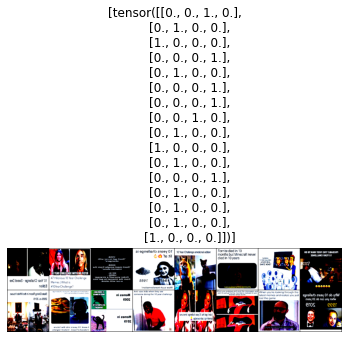

In [ ]:
# Check loaded data

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader))
show_databatch(inputs, classes)

### Definicja modelu i uczenie

Wybór modelu obrazu z dwóch przetestowanych modeli VGG16 i VGG19

In [ ]:
# avaliable models: vgg_16, vgg_19
image_model_type = 'vgg_16' # 'vgg_19'

Pobranie słownika stanu dla pretrenowanego VGG 16

In [ ]:
# Downloading pretrained vgg16

!gdown --id 1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl

Downloading...
From: https://drive.google.com/uc?id=1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl
To: /content/vgg16_bn.pth
100% 554M/554M [00:05<00:00, 98.1MB/s]


Zainicjowanie modelu VGG w wybranej wersji

In [ ]:
vgg = None

if image_model_type == 'vgg_16':
  vgg = models.vgg16_bn()
  vgg.load_state_dict(torch.load("/content/vgg16_bn.pth")) 
  print("Used model: VGG16")
elif image_model_type == 'vgg_19':
  vgg = models.vgg19_bn()
  print("Used model: VGG19")

Used model: VGG16


Określenie klasy _custom_vgg_, która pozwala odtworzyć architekturę baseline ze 
źródła: w porównaniu z bazowym VGG zmieniony jest klasyfikator, po wyciągnięciu
feature'ów przeprowadzany jest pooling, nastepnie wynik przekazywany jest do warstwy fully connected i poddawany funkcji sigmoid - wynikiem jest wektor czteroelementowy.

In [ ]:
# if use_trained_model==False:

  # Class with own modification of VGG16 architecture - classifier was changed - 
  # after getting features from image there is pooling layer, next results are flattened and feed to fully connected layer with output number = 4
  # at the end sigmoid function is used

class custom_vgg(nn.Module):
    """
        Custom vgg implementation as described baseline in in Memotion Analisys 
        task summary (https://arxiv.org/pdf/2008.03781.pdf)
    """
    def __init__(self, model):
        """
            Args:
                model: base VGG model downloaded from source
        """
        super(custom_vgg, self).__init__()

        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=25088, out_features=4, bias=True)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        """
            Args:
                x: object to perform learning on
        """
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.sigm(out)
        return out


Inicjalizacja modelu _custom_vgg_ na wgranym wcześniej modelu VGG

In [ ]:
# Loading custiom VGG16 from loaded, pretrained VGG16 model
vgg = custom_vgg(vgg)

# if use_trained_model==True:
#   vgg16.load_state_dict(torch.load('/content/drive/MyDrive/GSN_dataset/memotion_images_model.pt'))

Przełączenie na korzystanie z GPU jeżeli to możliwe oraz określenie krytrium, optimizera i schedulera dla pętli uczenia

In [ ]:
# Set VGG to run on GPU
if use_gpu:
    vgg.cuda()
    
criterion = nn.BCELoss()

# Define optimizer and LR Scheduler for training
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Definicja słownika danych dla obliczania makro F1 wraz z funkcjami operującymi na słowniku

In [ ]:
# F1 score calculating for image
image_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_image_f1_data():
    """
        Clearnig realted F1 data dict
    """
    for i in range(4):
        image_f1_data[i]["true_positive"] = 0.0
        image_f1_data[i]["false_positive"] = 0.0
        image_f1_data[i]["false_negative"] = 0.0

def update_image_f1_data(preditions: list, labels: list):
    """
        Updating F1 data dict with list of predicted class and actual labels
        Args:
            predictions (list): list of predicted classes with data in range 0-3
            labels (list): list of actual classes with data in range 0-3
    """
    for i in range(len(preditions)):
        if(preditions[i] == labels[i]):
            image_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            image_f1_data[labels[i]]["false_positive"] += 1.0
            image_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_image_f1_for_class(class_number: int):
    """
        Calculating F1 for given class number based on data in F1 data dict
        Args:
            class_number(int): Class number of which F1 will be calculated
    """
    precision_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_positive"]
    precision = (image_f1_data[class_number]["true_positive"] / precision_divider) if precision_divider > 0 else 0
    recall_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_negative"]
    recall = (image_f1_data[class_number]["true_positive"] / recall_divider) if recall_divider > 0 else 0
    #print(f"Precision: {precision} , Recall: {recall} ")
    return (2 * (precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

def calculate_image_macro_f1():
    """
        Calculates macro F1 based on F1 score of each class - based on `calculate_image_f1_for_class`
        function
    """
    macro_f1 = 0.0
    for i in range(4):
        macro_f1 += calculate_image_f1_for_class(i)
    return macro_f1/4

Definicja funkcji pomocniczej konwertującej klasy jako indeksy do macierzy, gdzie na pozycji indeksu znajduje się 1, przykład:
```
[0, 2, 1 ,3] = [[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1]]
```
Funckja potrzebna jest przy uczeniu

In [ ]:
def classes_convert(classes):
    """
        Converts list of indices (classes) to matrix with ones on position
        (x,y), where x = index in array, y = value on given position, ex:
        [0, 2, 1 ,3] = [[1, 0, 0, 0],
                        [0, 0, 1, 0],
                        [0, 1, 0, 0],
                        [0, 0, 0, 1]]
    """
    clas = []
    for element in range(len(classes)):
        var = classes[element]
        for index in range(len(var)):
        if var[index]==1:
            clas.append(index)
    return torch.tensor(clas)

In [ ]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}'"
                  .format(filename))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer

In [ ]:
# Defining training model
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=1, debug=False):
    """
    Args:
      vgg (nn.Model): Neural Network model to traing
      criterion (nn.LossFunction): Loss Function 
      optimizer (torch.optim): Optimalization Function
      scheduler (torch.optim.lr_scheduler): Learning Rate Scheduler
      num_epochs (int): Number of training epochs
      debug (boolean): Debug mode toogle
    """

    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloader)
    val_batches = len(dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        target_true = 0
        predicted_true = 0
        correct_true = 0
        
        vgg.train(True)
        clear_image_f1_data()
        for inputs, classes in iter(dataloader):
            if use_gpu:
                sample, clas = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                sample, clas = Variable(inputs), Variable(classes)
            
            # addressing batch labels to list
            batch_labels = []
            for row in clas.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            outputs = vgg(sample)

            if debug==True:
              print(outputs)
              print(clas)

            _, preds = torch.max(outputs.data, -1)
            loss = criterion(outputs, clas)
            
            loss.backward()
            optimizer.step()

            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            
            del sample, clas, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_train_macro_f1 = calculate_image_macro_f1()
        
        vgg.train(False)
        vgg.eval()
        clear_image_f1_data()    
        for inputs, classes in iter(dataloader):
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(classes)

            # addressing batch labels to list
            batch_labels = []
            for row in labels.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            # Prediction
            _, preds = torch.max(outputs.data, 1)
            if debug==True:
              print("Preds: ",preds)
            loss = criterion(outputs, labels)
            if debug==True:
              print("[1]Classes shape: ",classes.shape)
              print("[1]Classes: ",classes)

            classes = classes_convert(classes)
            if debug==True:
              print("[2]Classes: ",classes.shape)
              print("[2]Classes: ",classes)
            
            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_val_macro_f1 = calculate_image_macro_f1()

        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(epoch_train_macro_f1, epoch_val_macro_f1))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
if use_trained_model==False and image_model_continue_training == False:
  vgg = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=image_epochs, debug=False)
  if save_model:
    torch.save(vgg.state_dict(), image_save_model_path)
    print("Image model saved")
    checkpoint = {'state_dict': vgg.state_dict(), 'optimizer': optimizer_ft.state_dict()}
    torch.save(checkpoint, image_checkpoint_path)
    print("Checkpoint saved")

elif image_model_continue_training == True:
  
  checkpoint_model, optimizer = load_checkpoint(vgg, optimizer_ft,image_checkpoint_path)
  checkpoint_model = checkpoint_model.cuda()
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  for state in optimizer.state.values():
    for k,v in state.items():
      if isinstance(v, torch.Tensor):
        state[k] = v.cuda()
        
  vgg = train_model(checkpoint_model, criterion, optimizer, lr_scheduler, num_epochs=image_epochs, debug=False)
  if save_model:
    torch.save(vgg.state_dict(), image_save_model_path)
    print("Image model saved")
    checkpoint = {'state_dict': vgg.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, image_checkpoint_path)
    print("Checkpoint saved")
    

Epoch 0/25
----------
Image loading error for: ./MemotionAnalysis/images/image_3904.jpg


KeyboardInterrupt: ignored

## Gałąź przekształcania tekstu

### Utworzenie zbioru danych dla tekstu na podstawie zbioru z Kaggle

In [ ]:
# Text preprocessing

meme_text = dataset.data_info.iloc[:, 3]

raw_df = []

for i in range(len(meme_text)):
    raw_df.append([str(meme_text[i]), dataset.labels[i]])

df = pd.DataFrame(raw_df[:-3], columns=['text', 'label'])

text_field = Field(
    sequential=True,
    tokenize='basic_english', 
    fix_length=64,
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# prepocess
preprocessed_text = df['text'].apply(
    lambda x: text_field.preprocess(x)
)
# load fastext simple embedding with 100d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.6B.100d'
)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 27029.94it/s]


In [ ]:
class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) for i, r in df.iterrows()
            ], 
            fields
        )

train_dataset, test_dataset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', text_field),
        ('label', label_field)
    )
).split(split_ratio=0.85)

b_size = same_batch_size if use_trained_model else text_batch_size

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes=(b_size, b_size),
    sort=False
)

In [ ]:
text_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_text_f1_data():
    for i in range(4):
        text_f1_data[i]["true_positive"] = 0.0
        text_f1_data[i]["false_positive"] = 0.0
        text_f1_data[i]["false_negative"] = 0.0

def update_text_f1_data(preditions: list, labels: list):
    if type(preditions) is int:
      preditions = [preditions]
    if type(labels) is int:
      labels = [labels]
    for i in range(min(len(preditions), len(labels))):
        if(preditions[i] == labels[i]):
            text_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            text_f1_data[labels[i]]["false_positive"] += 1.0
            text_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_text_f1_for_class(class_number: int):
    if text_f1_data[class_number]["true_positive"] == 0:
      return 0
    precision = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_positive"])
    recall = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_negative"])
    # print(f"Precision: {precision} , Recall: {recall} ")
    return 2 * (precision * recall) / (precision + recall)

def calculate_text_macro_f1():
    macro_f1 = 0.0
    for i in range(4):
        macro_f1 += calculate_text_f1_for_class(i)
    return macro_f1/4

In [ ]:
def text_classes_convert(classes):
  y = classes
  # Actual conversion using y elements as index 
  M = np.zeros(len(y))

  for i in range(len(y)):
    M[i]=torch.argmax(y[i])
  return torch.tensor(M)

### BERT

In [ ]:
class BertDataset(Dataset):
    def __init__(self, df):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.labels = [np.argmax(l) for l in df['label']]
        self.data = [self.tokenizer(t, 
                            padding="max_length", max_length=128,
                            truncation=True, return_tensors="pt") for t in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.data[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

5585 698 699


In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
# Text model train - BERT

def train_bert(model, train_data, val_data, lr, epochs):
    train, val = BertDataset(train_data), BertDataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = lr)
    
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            clear_text_f1_data()
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                update_text_f1_data(output.argmax(dim=1).tolist(), train_label.squeeze().tolist())
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            epoch_train_macro_f1 = calculate_text_macro_f1()
            clear_text_f1_data()
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    update_text_f1_data(output.argmax(dim=1).tolist(), val_label.squeeze().tolist())
                    total_acc_val += acc
            epoch_val_macro_f1 = calculate_text_macro_f1()
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f} \
                | Train macro F1: {epoch_train_macro_f1} \
                | Val macro F1: {epoch_val_macro_f1} \
            ')
            if save_model:
                torch.save(model.state_dict(), text_save_model_path)
                print("Image model saved")
                checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, text_checkpoint_path)
                print("Checkpoint saved")

def evaluate_bert(model, test_data):

    test = BertDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    clear_text_f1_data()
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              update_text_f1_data(output.argmax(dim=1).tolist(), test_label.squeeze().tolist())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print("F1 score: {:.4f}".format(calculate_text_macro_f1()))

In [ ]:
EPOCHS = 10
bert_model = BertClassifier()
LR = 1e-6
              
train_bert(bert_model, df_train, df_val, LR, EPOCHS)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  5%|▍         | 126/2793 [00:10<03:33, 12.51it/s]


KeyboardInterrupt: ignored

In [ ]:
evaluate_bert(bert_model, df_test)

Test Accuracy:  0.280
F1 score: 0.2279


### LSTM

In [ ]:
# if use_trained_model==False:

class ModelParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 100)
        self.target_dim = param_dict.get('target_dim')
        
class TextModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        self.embedding = nn.Embedding(model_param.vocab_size, model_param.embedding_dim)
        self.conv = nn.Conv1d(64, 100, 4)
        self.max_pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(48, 16, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(in_features=3200, out_features=4, bias=True)
        self.sigm = nn.Sigmoid()
        self.flatt = nn.Flatten()
        # self.bert = BertModel.from_pretrained('bert-base-cased')
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    def forward(self, x):
        features = self.embedding(x)
        features = F.relu(features)
        # print(features.shape)
        features = self.conv(features)
        # print(features.shape)
        features = self.max_pool(features)
        # print(features.shape)
        features, hidden = self.lstm(features)
        # print(features.shape)
        features = self.flatt(features)
        features = self.fc(features)
        features = self.sigm(features)
        return features

In [ ]:
# Text model train - LSTM

if use_trained_model==False:
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=64,
        embedding_dim=100,
        target_dim=4
        )
    )
    train_text_model = TextModel(model_param).cuda()
    
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(train_text_model.parameters(), lr=0.0002)
    best_model_wts = copy.deepcopy(train_text_model.state_dict())
    best_val_f1 = -1
    epoch_count = 0
    losses = []
    val_losses = []
    val_acc = []
    for epoch in range(text_epochs):
        train_text_model.train()
        clear_text_f1_data()
        b_num = 0
        epoch_num = 0
        epoch_losses = []
        k = 0
        for batch in train_iter:
            optimizer.zero_grad()
            prediction = train_text_model(batch.text.T.cuda())
            batch_label = batch.label.to(torch.float)
            labels = text_classes_convert(batch_label).cuda()
            preds = torch.flatten(torch.max(prediction, 1)[1]).float().cuda()
            # print(prediction.shape)
            # print(batch.label.shape)
            loss = loss_function(torch.squeeze(prediction), torch.squeeze(batch.label.to(torch.float)).cuda())
            #update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
            # print(prediction)
            # print(batch.label)
            # print(preds)
            # print(labels)
            update_text_f1_data(preds.tolist(), labels.tolist())
            loss.backward()
            epoch_losses.append(loss.item())
            optimizer.step()
            k = k+1
        
        losses.append(sum(epoch_losses)/k)
        train_text_macro_f1 = calculate_text_macro_f1()
        
        train_text_model.eval()
        clear_text_f1_data()
        val_epoch_losses = []
        k = 0
        total_acc_val = 0
        
        test_iter_elements_number = 0
        for batch in test_iter:
            with torch.no_grad():
                optimizer.zero_grad()
                prediction = train_text_model(batch.text.T.cuda())
                batch.label = batch.label.to(torch.float)
                labels = text_classes_convert(batch.label).cuda()
                # preds = torch.flatten(torch.max(prediction, 1)[1]).float().cuda()
                _, preds = torch.max(prediction, 1)
                # print(preds)
                # print(preds2)
                loss = loss_function(torch.squeeze(prediction), torch.squeeze(batch.label.to(torch.float)).cuda())
                #update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
                # print(prediction)
                # print(batch.label)
                # print(preds)
                # print(labels)
                
                test_iter_elements_number += len(labels)
                acc = (preds == labels).sum().item()
                # print(acc)
                # print(loss)
                total_acc_val += acc
                val_epoch_losses.append(loss.item())
                update_text_f1_data(preds.tolist(), labels.tolist())
                k = k+1

        # print(total_acc_val)
        # print(test_iter_elements_number)
        val_acc.append(total_acc_val / test_iter_elements_number)
        val_losses.append(sum(val_epoch_losses)/k)
        val_text_macro_f1 = calculate_text_macro_f1()
        if val_text_macro_f1 > best_val_f1:
            best_val_f1 = val_text_macro_f1
            best_model_wts = copy.deepcopy(train_text_model.state_dict())
        else :
            train_text_model.load_state_dict(best_model_wts)
        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(train_text_macro_f1, val_text_macro_f1))
        print('-' * 10)
        print()
    print(f"Best val f1 score: {best_val_f1}")
    if save_model:
        torch.save(best_model_wts, text_save_model_path)
        print("Text model saved")


Epoch 0 result: 
F1 score: 0.2187 (train), 0.1287 (val)
----------



KeyboardInterrupt: ignored

## Testowanie wytrenowanych modeli

In [ ]:
class TestDataset(Dataset):
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        self.debug = debug
        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        
        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []
        self.text_arr = self.data_info.iloc[:, 3]
        raw_df = []

        for i in range(len(self.text_arr)):
            raw_df.append([str(self.text_arr[i])])
        self.df = pd.DataFrame(raw_df[:-2], columns=['text'])

        self.text_field = Field(
            sequential=True,
            tokenize='basic_english', 
            fix_length=50, 
            lower=True
        )
        # prepocess
        preprocessed_text = self.df['text'].apply(
            lambda x: self.text_field.preprocess(x)
        )
        # load fastext simple embedding with 100d
        self.text_field.build_vocab(
            preprocessed_text, 
            vectors='glove.6B.100d'
        )

        class DataFrameDataset(Dataset):
            def __init__(self, df: pd.DataFrame, fields: list):
                super(DataFrameDataset, self).__init__(
                    [
                        Example.fromlist(list(r), fields) for i, r in df.iterrows()
                    ], 
                    fields
                )
        self.text_dataset = DataFrameDataset(
            df=df, 
            fields=(
                ('text', text_field),
            )
        )

        self.text_iter = BucketIterator(
            dataset=train_dataset, 
            batch_size=1
        )

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

    def __getitem__(self, index):
        """
        Args:
          index (int): index of item to get  

        Returns:
          Tuple of image, text and class vector as tensors
        """
        img_as_img = None
        single_image_name = None

        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          label = self.labels[index]

          if self.debug==True:
            print('3:',label)

          # Convert class vector to tensor
          label = torch.as_tensor(label)
          
          if self.debug==True:
            print('4:',label)

          text_data = next(iter(self.text_iter)).text

          if self.debug==True:
            print('5:',text_data)

          return (img_as_tensor, text_data, label)
        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))
    
    def __len__(self):
        return self.data_len    


In [ ]:
dataset = TestDataset('MemotionAnalysis/labels.csv', low_data_mode=False, debug=False)

# Loading dataset into DataLoader and setting batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=1)

In [ ]:
image, text, label = next(iter(dataloader))
print(image.shape)
print(text.shape)
print(label.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 50, 1])
torch.Size([4, 4])


In [ ]:
text_model, image_model = None, None
if use_trained_model:
    text_model_dict = torch.load(text_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    image_model_dict = torch.load(image_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    vgg16 = models.vgg16_bn()
    vgg16.load_state_dict(torch.load("/content/vgg16_bn.pth")) 
    image_model = custom_vgg16(vgg16)
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=50,
        embedding_dim=100,
        target_dim=4
        )
    )
    text_model = TextModel(model_param)
    image_model.load_state_dict(image_model_dict)
    text_model.load_state_dict(text_model_dict)
else:
    text_model = train_text_model
    image_model = vgg16

In [ ]:
print(text_model)
print(image_model)

TextModel(
  (embedding): Embedding(13676, 100)
  (conv): Conv1d(50, 4, kernel_size=(1,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(50, 16)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigm): Sigmoid()
)
custom_vgg16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    

In [ ]:
def get_labels_as_indices(labels_data):
    return torch.flatten(torch.max(labels_data, 1)[1]).float()

In [ ]:
def predict(image_data, text_data):
    image_pred = image_model(image_data)
    text_pred = torch.squeeze(text_model(text_data))
    preds = image_pred*0.3 + text_pred*0.7
    images_preds = get_labels_as_indices(image_pred)
    text_preds = get_labels_as_indices(text_pred)
    print(f"Image pred: {images_preds}")
    print(f"Text pred: {text_preds}")
    preds = get_labels_as_indices(preds)
    return preds

In [ ]:
# image_inputs, image_classes = next(iter(dataloader))
# text_data = next(iter(train_iter))

image_data, text_data, label = next(iter(dataloader))

preds = predict(image_data, torch.squeeze(text_data))

print(preds)
print(get_labels_as_indices(label))
# print(get_labels_as_indices(text_data.label))

Image pred: tensor([2., 2., 2., 1.])
Text pred: tensor([3., 3., 3., 1.])
tensor([2., 2., 3., 1.])
tensor([2., 1., 0., 3.])
